In [25]:
import pickle

all_dict = pickle.load(open('results/all_dict.pkl', 'rb'))
all_dict.keys() 

dict_keys(['cropped_filenames', 'cropped_imgs', 'cropped_segments', 'aspect_ratios', 'widths', 'heights', 'noses'])

In [29]:
noses = all_dict['noses']
widths = all_dict['widths']
heights = all_dict['heights']
imgs = all_dict['cropped_imgs']
segments = all_dict['cropped_segments']

In [23]:
img = all_dict['cropped_imgs'][0]
segment = all_dict['cropped_segments'][0]
nose = all_dict['noses'][0]

In [17]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt

def polygon_overlay_image(image, segments): 
  overlay = image.copy()
  alpha = 0.5 

  for label, polygons in segments.items(): 
    for polygon in polygons:
      int_coords = lambda x: np.array(x).round().astype(np.int32)
      exterior = [int_coords(polygon.exterior.coords)]

      cv2.fillPoly(overlay, exterior, color=(255, 255, 0))
      cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
  return overlay

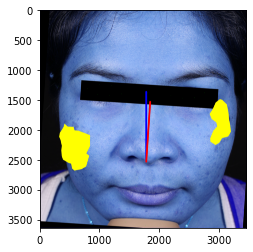

In [19]:
overlay = polygon_overlay_image(img, segment)
plt.imshow(overlay)

In [69]:
import math 
# maximum distance between nose and the bottom frame of image 
max_nose_height = max([(height - nose[1]) for height, nose in zip(heights, noses)])

# min pad to get nose at the center y 
padded_heights = [] 
for height, nose in zip(heights, noses): 
    nose_height_to_max_nose_height = (height - nose[1]) - (max_nose_height) 
    padded_heights.append(height + nose_height_to_max_nose_height)

# min pad to get nose at the center x 
padded_widths = [] 
for width, nose in zip(widths, noses): 
    padded_widths.append(width + abs(width // 2 - nose[0]))

max_padded_width = math.ceil(max(padded_widths))
max_padded_height = math.ceil(max(padded_heights))
print(max_padded_width, max_padded_height)

3558 3925


In [70]:
import shapely 
from collections import defaultdict
standard_nose = (max_padded_width//2, max_padded_height - max_nose_height) # depending on the dataset 
translated_segments = defaultdict(list)
for nose, segment in zip(list(noses), segments):  
    xoff = standard_nose[0] - nose[0]
    yoff = standard_nose[1] - nose[1]
    print(f'nose = {nose}')
    print(f'standard_nose = {standard_nose}')
    print(f'xoff = {xoff}')
    print(f'yoff = {yoff}')
    for label, polygons in segment.items(): 
        for polygon in polygons:
            translated_segments[label].append(shapely.affinity.translate(polygon, xoff=xoff, yoff=yoff))

nose = [1774.35948944 4076.90104866]
standard_nose = (1779, 3760.4947214126587)
xoff = 4.640510559082031
yoff = -316.40632724761963
nose = [1697.49934387 4071.62806678]
standard_nose = (1779, 3760.4947214126587)
xoff = 81.50065612792969
yoff = -311.1333453655243
nose = [1719.47085232 3962.19413757]
standard_nose = (1779, 3760.4947214126587)
xoff = 59.52914768457413
yoff = -201.6994161605835
nose = [1626.7563858  3760.49472141]
standard_nose = (1779, 3760.4947214126587)
xoff = 152.24361419677734
yoff = 0.0
nose = [1694.86828995 4003.28911805]
standard_nose = (1779, 3760.4947214126587)
xoff = 84.13171005249023
yoff = -242.79439663887024
nose = [1723.25967169 4071.28594023]
standard_nose = (1779, 3760.4947214126587)
xoff = 55.740328311920166
yoff = -310.79121881723404


In [75]:
from shapely.geometry import Polygon
def create_face_heatmaps(max_width, max_height, segments, patch_size=(100,100)):
    num_y = math.ceil(max_height / patch_size[0])
    num_x = math.ceil(max_width / patch_size[1])

    face_heatmaps = dict() 
    err_polygons = list()
    err_current_rects = list()
    for label in segments.keys():
      face_heatmap = np.zeros((num_y, num_x))
      for i in range(num_y):  
          for j in range(num_x): 
              current_rect = Polygon([
                  [j*patch_size[1], i*patch_size[0]], 
                  [j*patch_size[1] + patch_size[1], i*patch_size[0]],
                  [j*patch_size[1] + patch_size[1], i*patch_size[0] + patch_size[0]],
                  [j*patch_size[1], i*patch_size[0] + patch_size[0]] 
              ]) 
              for polygon in segments[label]: 
                try: 
                  area = current_rect.intersection(polygon).area * 1. / current_rect.area
                except:
                  area = current_rect.intersection(polygon.buffer(0)).area * 1. / current_rect.area
                if area > 0:
                  face_heatmap[i][j] += 1
      face_heatmaps[label] = face_heatmap
    return face_heatmaps

In [76]:
# for label, polygons in translated_segments.items():
#     for polygon in polygons: 
#         print(f'polygon = {list(polygon.exterior.coords)}')

In [77]:
face_heatmaps = create_face_heatmaps(max_padded_width, max_padded_height, translated_segments, patch_size=(100,100))

Input geom 1 is INVALID: Self-intersection at or near point 916.06441446502185 1678.9014956536032 (916.06441446502185499 1678.9014956536032059)
<A>
6441446502185 1678.9014956536032
POLYGON ((677.3371952379097820 1452.2728182306527742, 593.5875547829141397 1501.5723331177528053, 526.6437406180884864 1534.3455127105357860, 442.6146091672405873 1616.9771891821228564, 400.0410614501126929 1724.9573505868902430, 540.4313758662467535 1894.8071227553186873, 654.9526364380751602 1867.1949533829656502, 748.3455334868610862 1803.6900809584717535, 826.9740910065485195 1797.2062751091616519, 898.6397152554653758 1769.2347601707128888, 948.4582848491476170 1791.0818148259468217, 927.4497031814701131 1740.9038996661688543, 920.5466608383816265 1712.2735845232114116, 935.0714366567492561 1683.8229421633022866, 906.5609033691573586 1676.4407723987533245, 920.7862245491120348 1683.7031603079367414, 899.5380791707042363 1662.0956693634334442, 864.3640672507542604 1597.5127602406528240, 835.9733158185272

In [79]:
import plotly.express as px
import plotly.graph_objects as go 
fig = go.Figure()

buttons = [] 
visible_list = [False] * (len(face_heatmaps.keys()) + 1)


for idx, (label, heatmap_data) in enumerate(face_heatmaps.items()):
    fig.add_trace(go.Heatmap(z=face_heatmaps[label][::-1]))

current_visible_list = visible_list.copy()
current_visible_list[0] = True
current_visible_list[idx+1] = True
button = dict(
    method='update',
    label=label, 
    args=[{'visible': current_visible_list}]
)
buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=buttons[::-1],
            pad={"l":70, "t": -10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        
    ], 
    width=500,
    height=600
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="Segment type:", showarrow=False,
                            x=5, y=1.10, yref="paper", align="left")
    ]
)

fig.show()